In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os.path as path
import os

In [18]:
plt.style.use('default')

In [19]:
def plot_thrpt(data, x_col, lines_cols, mapper=lambda x: x, nc=3):
    data = data[~data["DSU"].str.contains(':')]
    data = mapper(data).copy()
    
    if type(lines_cols) != list:
        lines_cols = [lines_cols]
    params = data.columns.drop(["Score", "Score Error", x_col] + lines_cols)
    unique_index = data[params].drop_duplicates()
    
    n = (len(unique_index) + nc-1) // nc
    if n == 0:
        fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)
        ax = list(ax)
    else:
        fig, ax = plt.subplots(figsize=(8*nc, 6 * n), ncols=nc, nrows=n)
        ax = list(ax.flat)

    for _, index in unique_index.iterrows():
        plt.sca(ax[0])
        ax = ax[1:]
        
        ttl = ''
        for i, c in enumerate(unique_index.columns):
            if ttl != '':
                ttl += ', '
            ttl += c + '=' + str(index[i])
        plt.title(ttl)
        
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        lines_index = fig_data[lines_cols].drop_duplicates()
        
        for _, l_index in lines_index.iterrows():
            lbl = ', '.join(map(str, l_index))
            line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
            x = line_data[x_col]
            y = line_data["Score"]
            e = line_data["Score Error"]
            l = plt.errorbar(x, y, yerr=e, capsize=3, label=lbl)
        if x_col == 'sameSetFraction':
            plt.xlabel("Same Set requests fraction")
        else:
            plt.xlabel(x_col)
        plt.ylabel("Throughput (ops/s)")
#         y_min, y_max = plt.ylim()
#         plt.ylim(2.5e6, 5.5e6)
        plt.legend()
        plt.grid()
    plt.suptitle("Throughput")

In [47]:
def plot_met(data, metric, x_col, lines_cols, mapper=lambda x: x, nc=3):
    data = data[data["DSU"].str.endswith(':' + metric)]
    data = mapper(data).copy()
    data["DSU"] = data["DSU"].str[:-len(metric) - 1]
    
    if type(lines_cols) != list:
        lines_cols = [lines_cols]
    params = data.columns.drop(["Score", "Score Error", x_col] + lines_cols)
    unique_index = data[params].drop_duplicates()
    
    n = (len(unique_index) + nc - 1) // nc
    if len(unique_index) == 1:
        fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1)
        ax = [ax]
    else:
        fig, ax = plt.subplots(figsize=(8 * nc, 6 * n), ncols=nc, nrows=n)
        ax = list(ax.flat)

    for _, index in unique_index.iterrows():
        plt.sca(ax[0])
        ax = ax[1:]
        
        ttl = ''
        for i, c in enumerate(unique_index.columns):
            if ttl != '':
                ttl += ', '
            ttl += c + '=' + str(index[i])
        plt.title(ttl)
        
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        lines_index = fig_data[lines_cols].drop_duplicates()
        
        for _, l_index in lines_index.iterrows():
            lbl = ', '.join(map(str, l_index))
            line_data = fig_data[(fig_data[lines_cols] == l_index).all(axis=1)]
            x = line_data[x_col]
            y = line_data["Score"]
            e = line_data["Score Error"]
            l = plt.errorbar(x, y, yerr=e, capsize=3, label=lbl)
        plt.xlabel(x_col)
        plt.ylabel(metric)
        plt.legend()
        plt.grid()

In [21]:
def emit_metric(data, producer):
    data = data[data["DSU"].str.contains(':')]

    def fix(mrow):
        dsu = mrow["DSU"][:mrow["DSU"].find(':')]
        mname = mrow["DSU"][mrow["DSU"].find(':') + 1:]
        mrow = mrow.copy()
        mrow["DSU"] = dsu
        mrow["Metric"] = mname
        return mrow
    def unfix(mrow):
        dsu = mrow["DSU"]
        mname = mrow["Metric"]
        mrow = mrow.copy().drop("Metric")
        mrow["DSU"] = dsu + ':' + mname
        return mrow
    
    data = data.apply(fix, axis=1)
    
    params = data.columns.drop(["Score", "Score Error", "Metric"])
    unique_index = data[params].drop_duplicates()

    series = []
    for _, index in unique_index.iterrows():
        fig_data = data[(data[unique_index.columns] == index).all(axis=1)]
        y = producer(fig_data)
        if y is not None:
            series.append(y)
    data = pd.concat([data, pd.DataFrame(series)])
    return data.apply(unfix, axis=1)

In [39]:
def strip_subtype(compose=lambda x: x):
    def prod(r):
        r = r.copy()
        r["DSU"] = r["DSU"].replace('/halfing', '').replace('/squashing', '')
        return r
    def f(x):
        x = compose(x)
        x = x.apply(prod, axis=1)
        return x
    return f

def cut_field(field, compose=lambda x: x):
    def f(x):
        x = compose(x)
        x = x.drop(field, axis=1)
        return x
    return f

def halfing_dsus(x):
    s = x['DSU'].str
#     return x[(s.contains('halfing') | s.contains('Usual')) & ~(s.contains("Adaptive/") | s.contains("AdaptiveLocks/"))]
    return x[(s.contains('halfing') | s.contains('Usual')) & ~s.contains("Locks/")]

def halfing_dsus_nu(x):
    s = x['DSU'].str
    x = x[(s.contains('halfing')) & ~s.contains("Locks/") & ~s.contains("Lazy")]
    return x

def squashing_dsus(x):
    s = x['DSU'].str
    return x[s.contains('squashing') | s.contains('Usual')]

def param_in(param, vals, compose=lambda x: x):
    if type(vals) != list:
        vals = [vals]
    def f(data):
        data = compose(data)
        flt = data[param] == vals[0]
        for v in vals[1:]:
            flt = flt | (data[param] == v)
        return data[flt]
    return f

def ssf_in(vals, compose=lambda x: x):
    return param_in('sameSetFraction', vals, compose)

def ipf_in(vals, compose=lambda x: x):
    return param_in('interpairFraction', vals, compose)

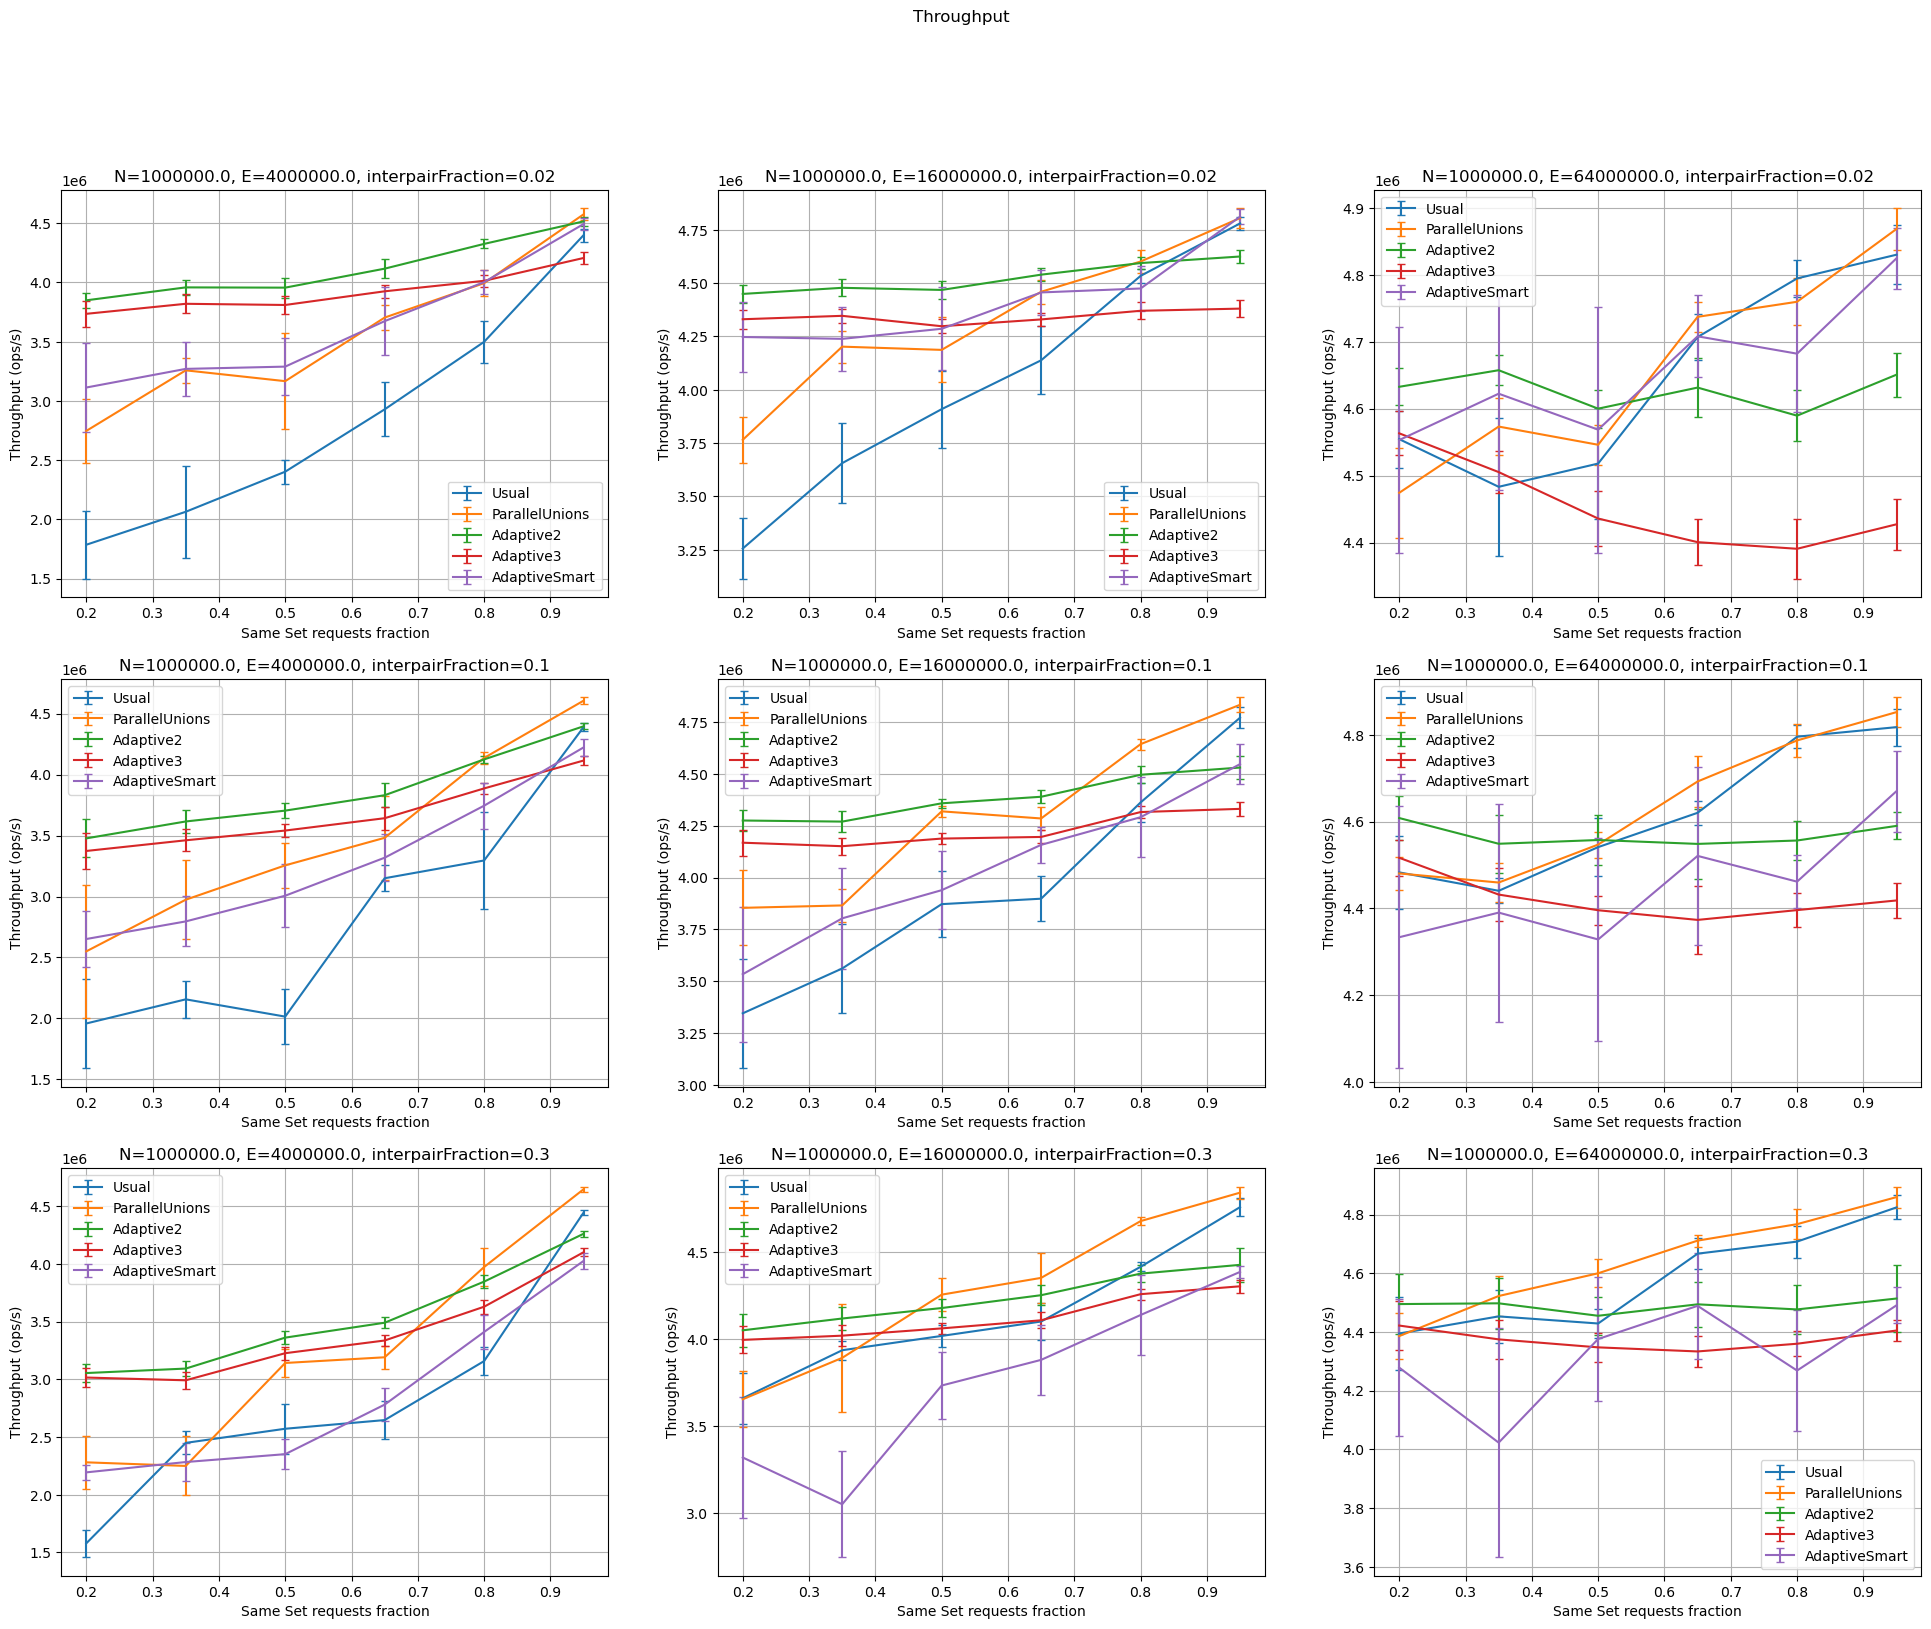

In [23]:
# d1 = pd.read_csv("measurements/out-old6.csv")
# d1 = d1[d1["interpairFraction"] < 0.5]
# d2 = pd.read_csv("measurements/out-old8.csv")
data = pd.concat([
    pd.read_csv("measurements/out-shuffled-without-metrics.csv"),
    pd.read_csv("measurements/out-smart-shuffled-without-metrics.csv"),
]).drop("shuffleVertices", axis=1)
# d3 = d3[d3["DSU"].str.contains('2') | d3["DSU"].str.contains('3')]
# data = pd.concat([d1, d2])
# data = data[data["E"] < 60000000]
plot_thrpt(data, "sameSetFraction", "DSU", strip_subtype(halfing_dsus), nc=3)

In [24]:
# d1 = pd.read_csv("measurements/out-old6.csv")
# d1 = d1[d1["interpairFraction"] < 0.5]
# d2 = pd.read_csv("measurements/out-old8.csv")
# d0 = pd.concat([d1, d2])
# d0 = d0[d0["DSU"].str.contains("Parallel") | d0["DSU"].str.contains("Adaptive")]
# d3 = pd.read_csv("measurements/out.csv")
# d3 = d3[~d3["DSU"].str.contains("Parallel")]
# data = pd.concat([d0, d3])
# data = data[(data["E"] < 60000000) & (data["sameSetFraction"] > 0.11)]
# plot_thrpt(data, "sameSetFraction", "DSU", ipf_in([0.1, 0.3], strip_subtype(halfing_dsus_nu)), nc=2)

# Metrics

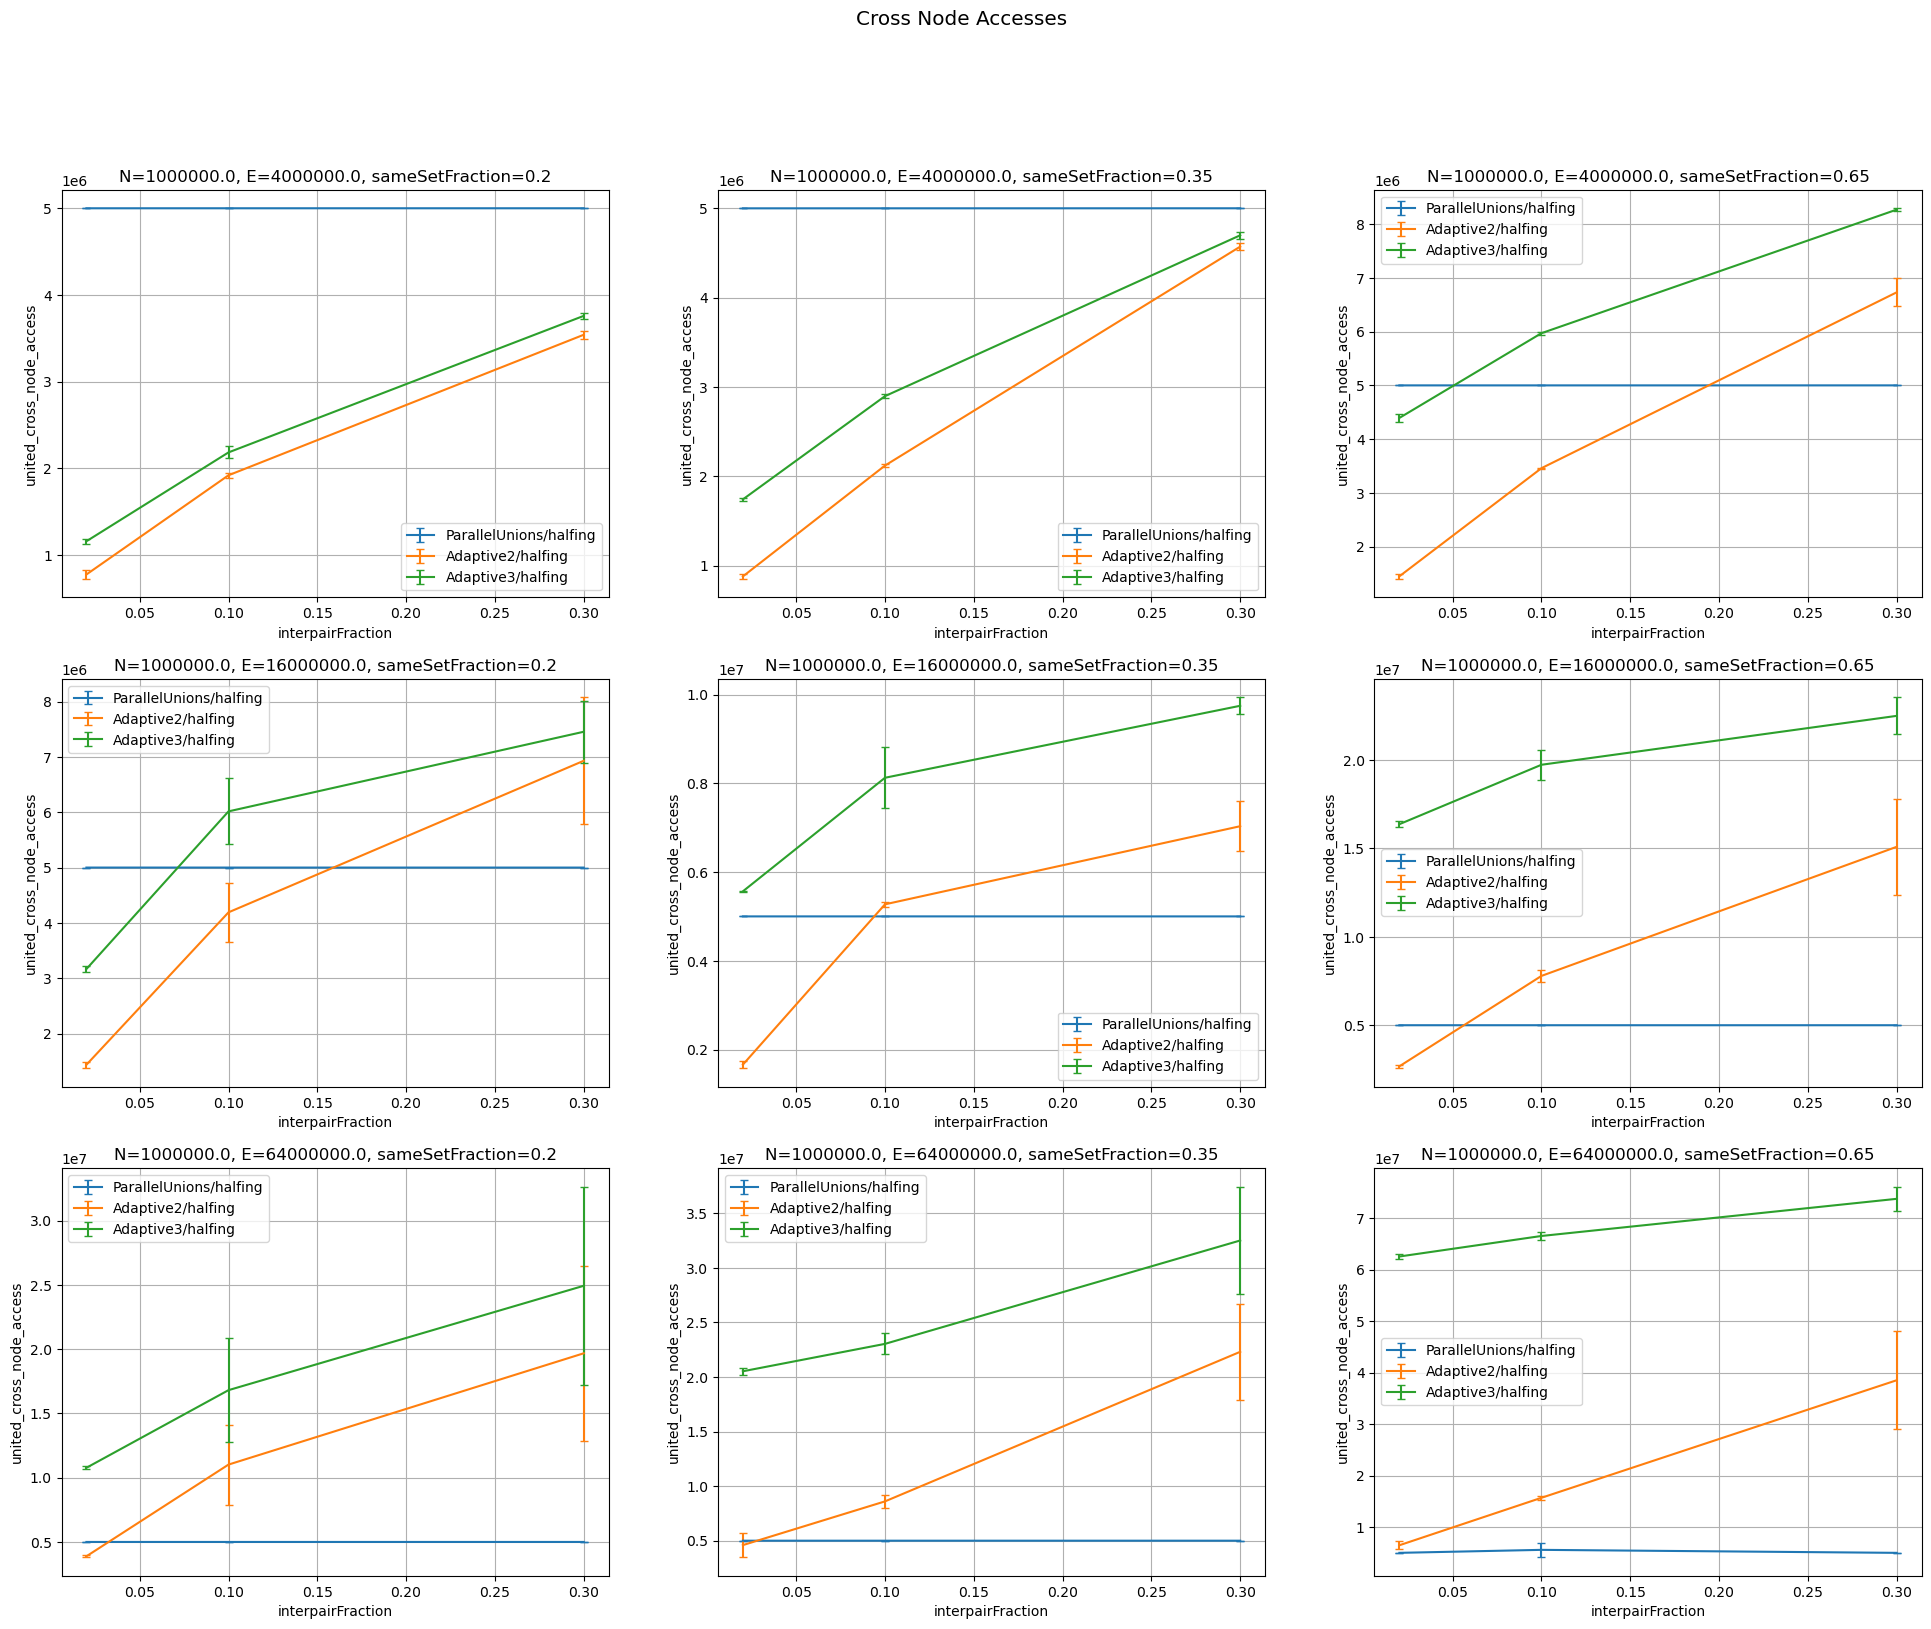

In [25]:
def prod_united(rows):
    res = rows.reset_index(inplace=False).loc[1].copy()
    rows = rows.set_index("Metric")
    score = rows.loc["cross_node_write"]["Score"] + rows.loc["cross_node_read"]["Score"] + rows.loc["global_data_read_write"]["Score"]
    err = rows.loc["cross_node_write"]["Score Error"] + rows.loc["cross_node_read"]["Score Error"] + rows.loc["global_data_read_write"]["Score Error"]
    res["Metric"] = "united_cross_node_access"
    res["Score"] = score
    res["Score Error"] = err
    res = res.drop("index")
    return res

def good_dsus(x):
    s = x['DSU'].str
    return x[s.contains('halfing') & (s.contains('Adaptive2') | s.contains('Adaptive3') | s.contains('Parallel'))]

met = pd.read_csv('measurements/out-shuffled-with-metrics.csv').sort_values(axis=0, by="E", kind='stable')

m2 = emit_metric(met, prod_united)
m2 = m2
plot_met(m2, "united_cross_node_access", "interpairFraction", "DSU", ssf_in([0.2, 0.35,0.65], halfing_dsus_nu))
plt.suptitle("Cross Node Accesses", fontsize='x-large');

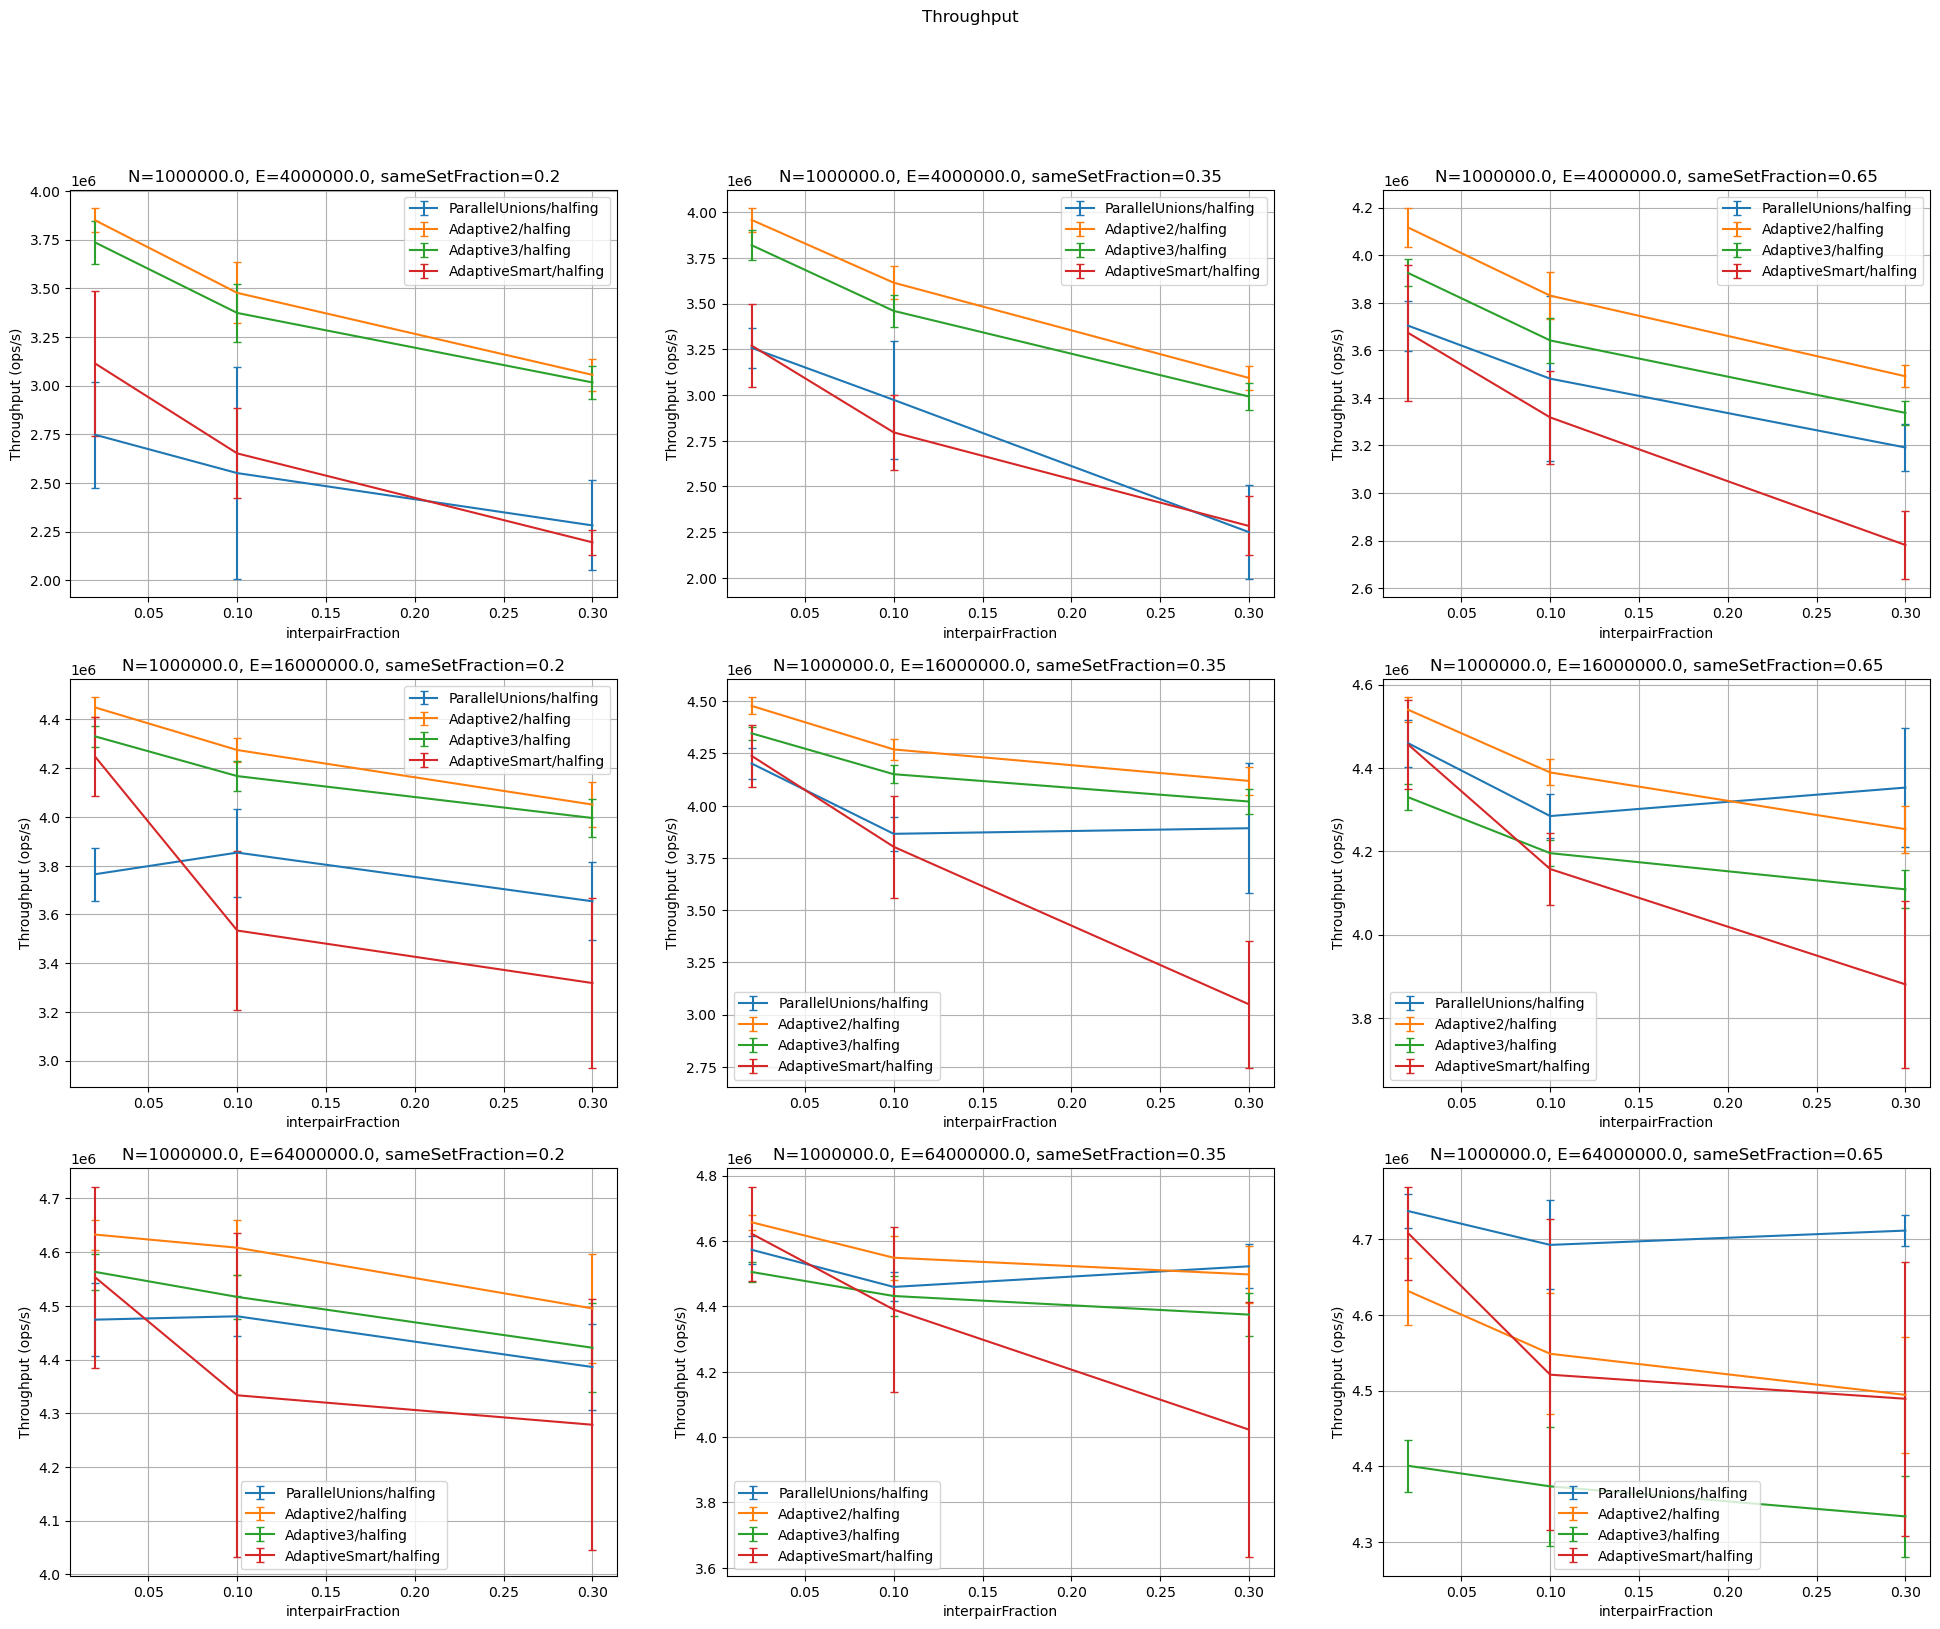

In [26]:
plot_thrpt(data.sort_values(by="E", kind="stable"), "interpairFraction", "DSU", ssf_in([0.2, 0.35,0.65], halfing_dsus_nu))

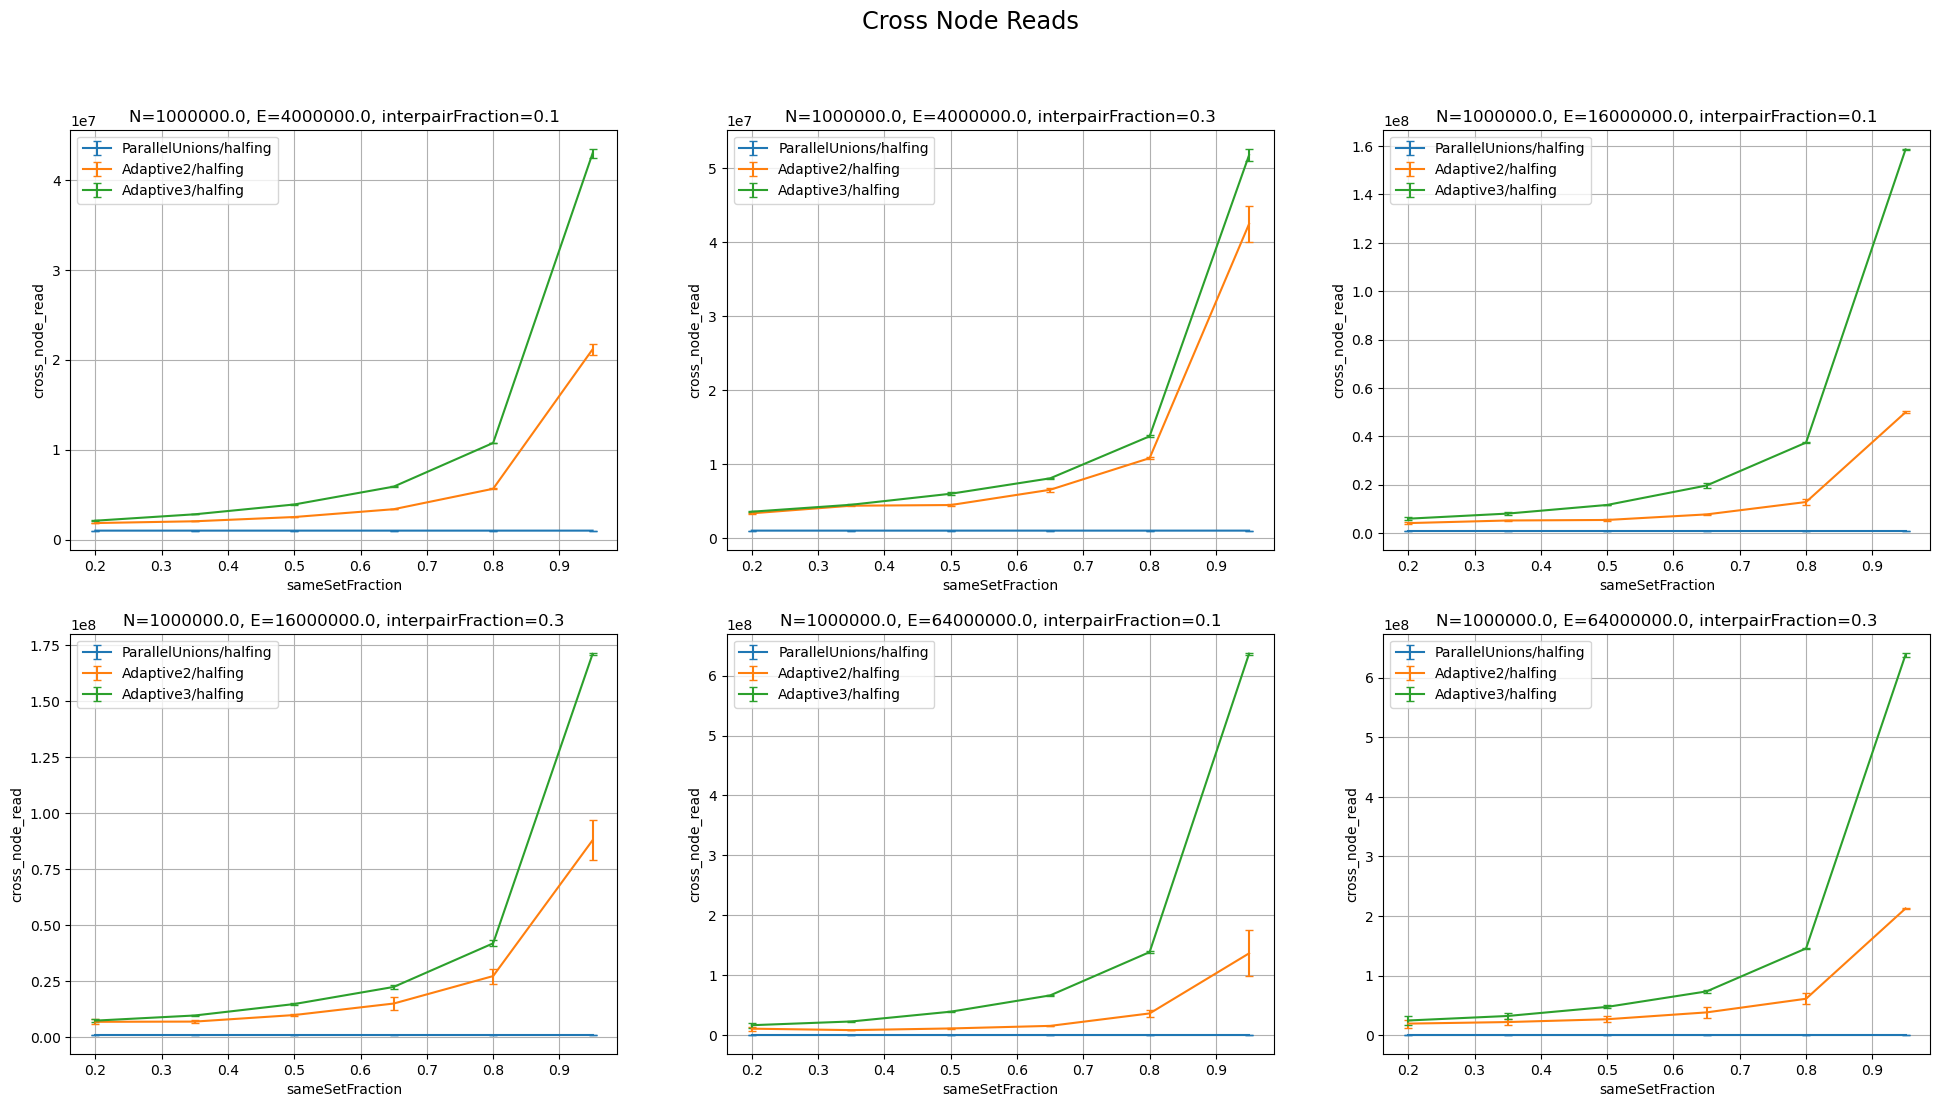

In [27]:
plot_met(met, "cross_node_read", "sameSetFraction", "DSU", ipf_in([0.1, 0.3], halfing_dsus_nu))
plt.suptitle("Cross Node Reads", fontsize='xx-large');

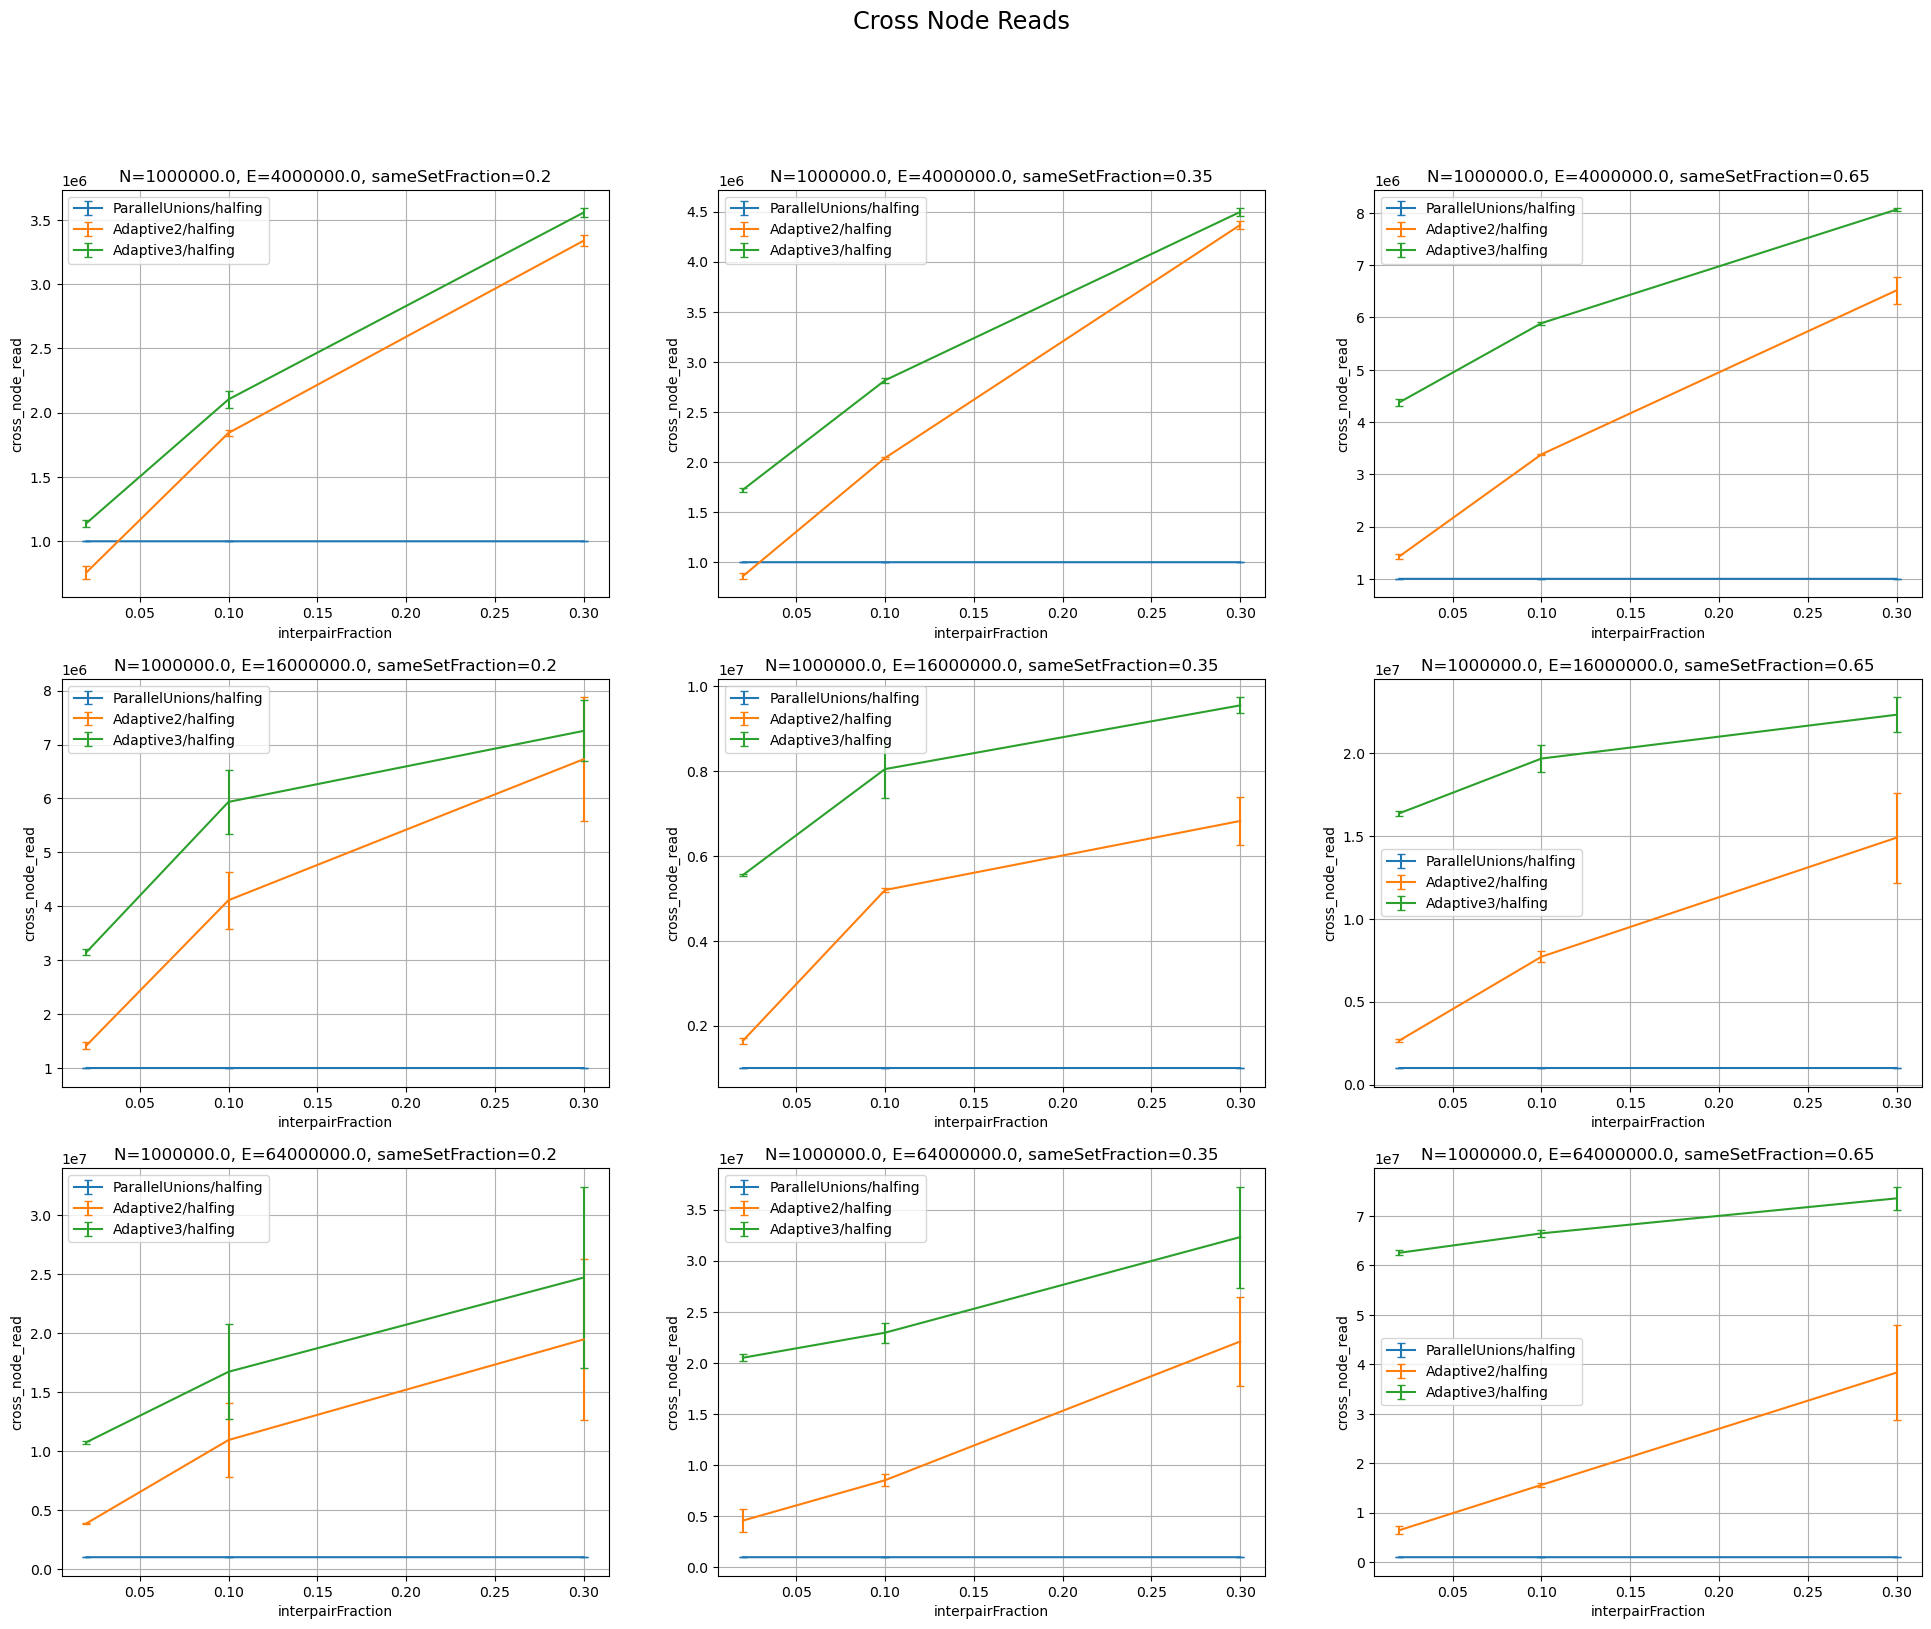

In [28]:
plot_met(met, "cross_node_read", "interpairFraction", "DSU", ssf_in([0.2, 0.35, 0.65], halfing_dsus_nu))
plt.suptitle("Cross Node Reads", fontsize='xx-large');

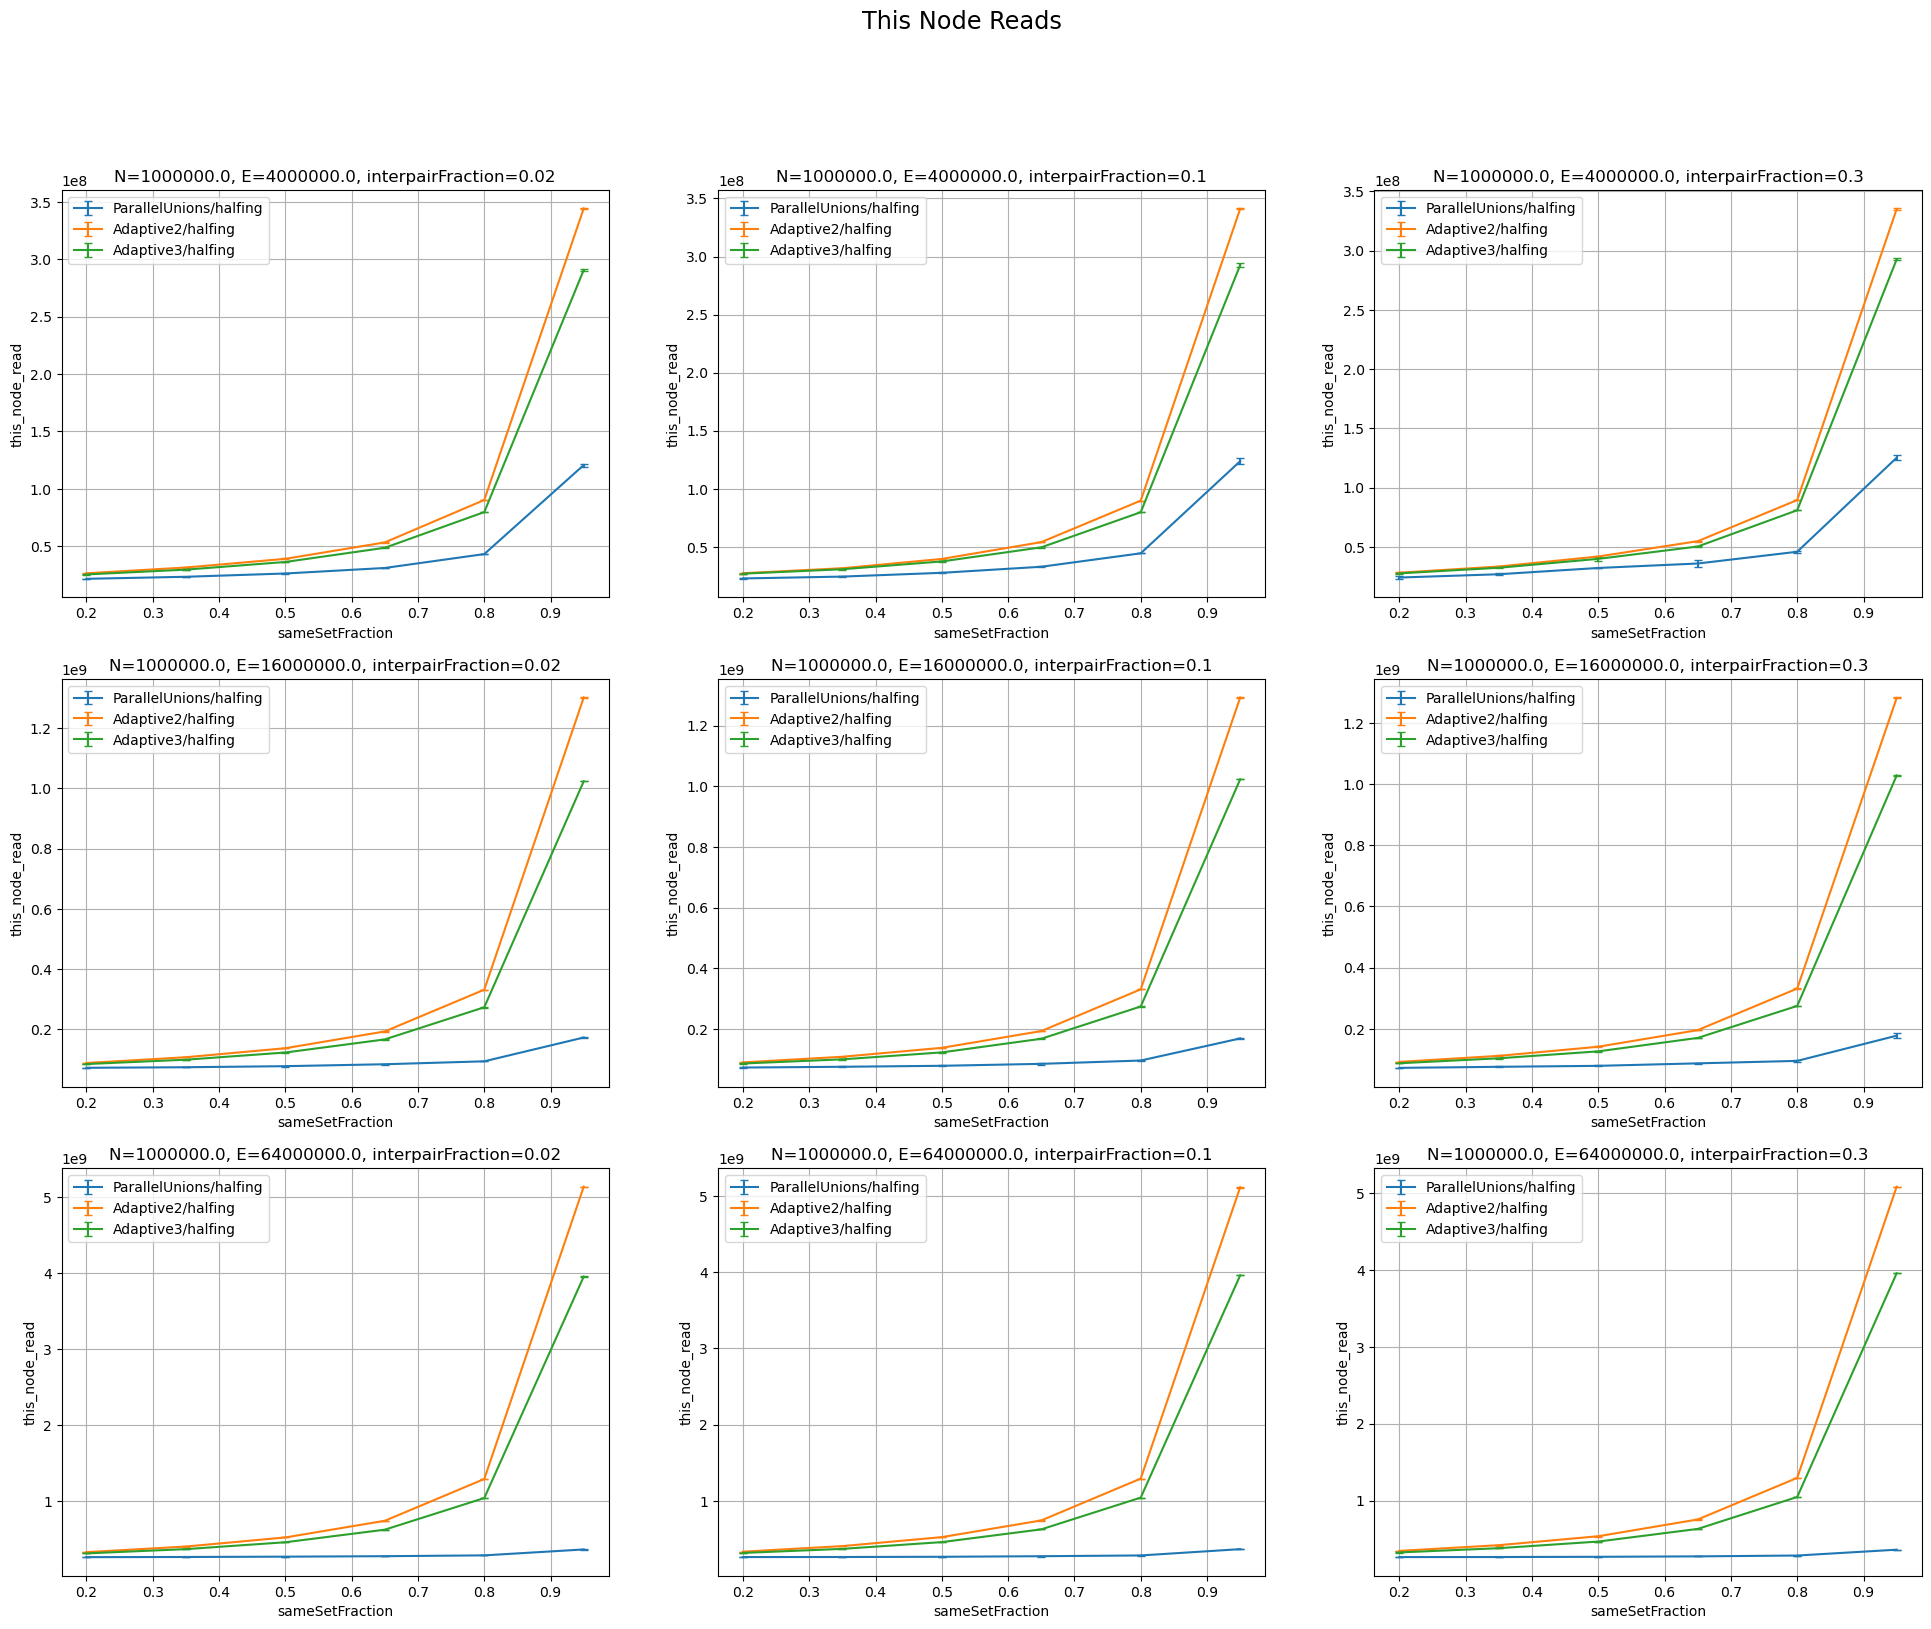

In [29]:
plot_met(met, "this_node_read", "sameSetFraction", "DSU", ipf_in([0.02, 0.1, 0.3], halfing_dsus_nu))
plt.suptitle("This Node Reads", fontsize='xx-large');

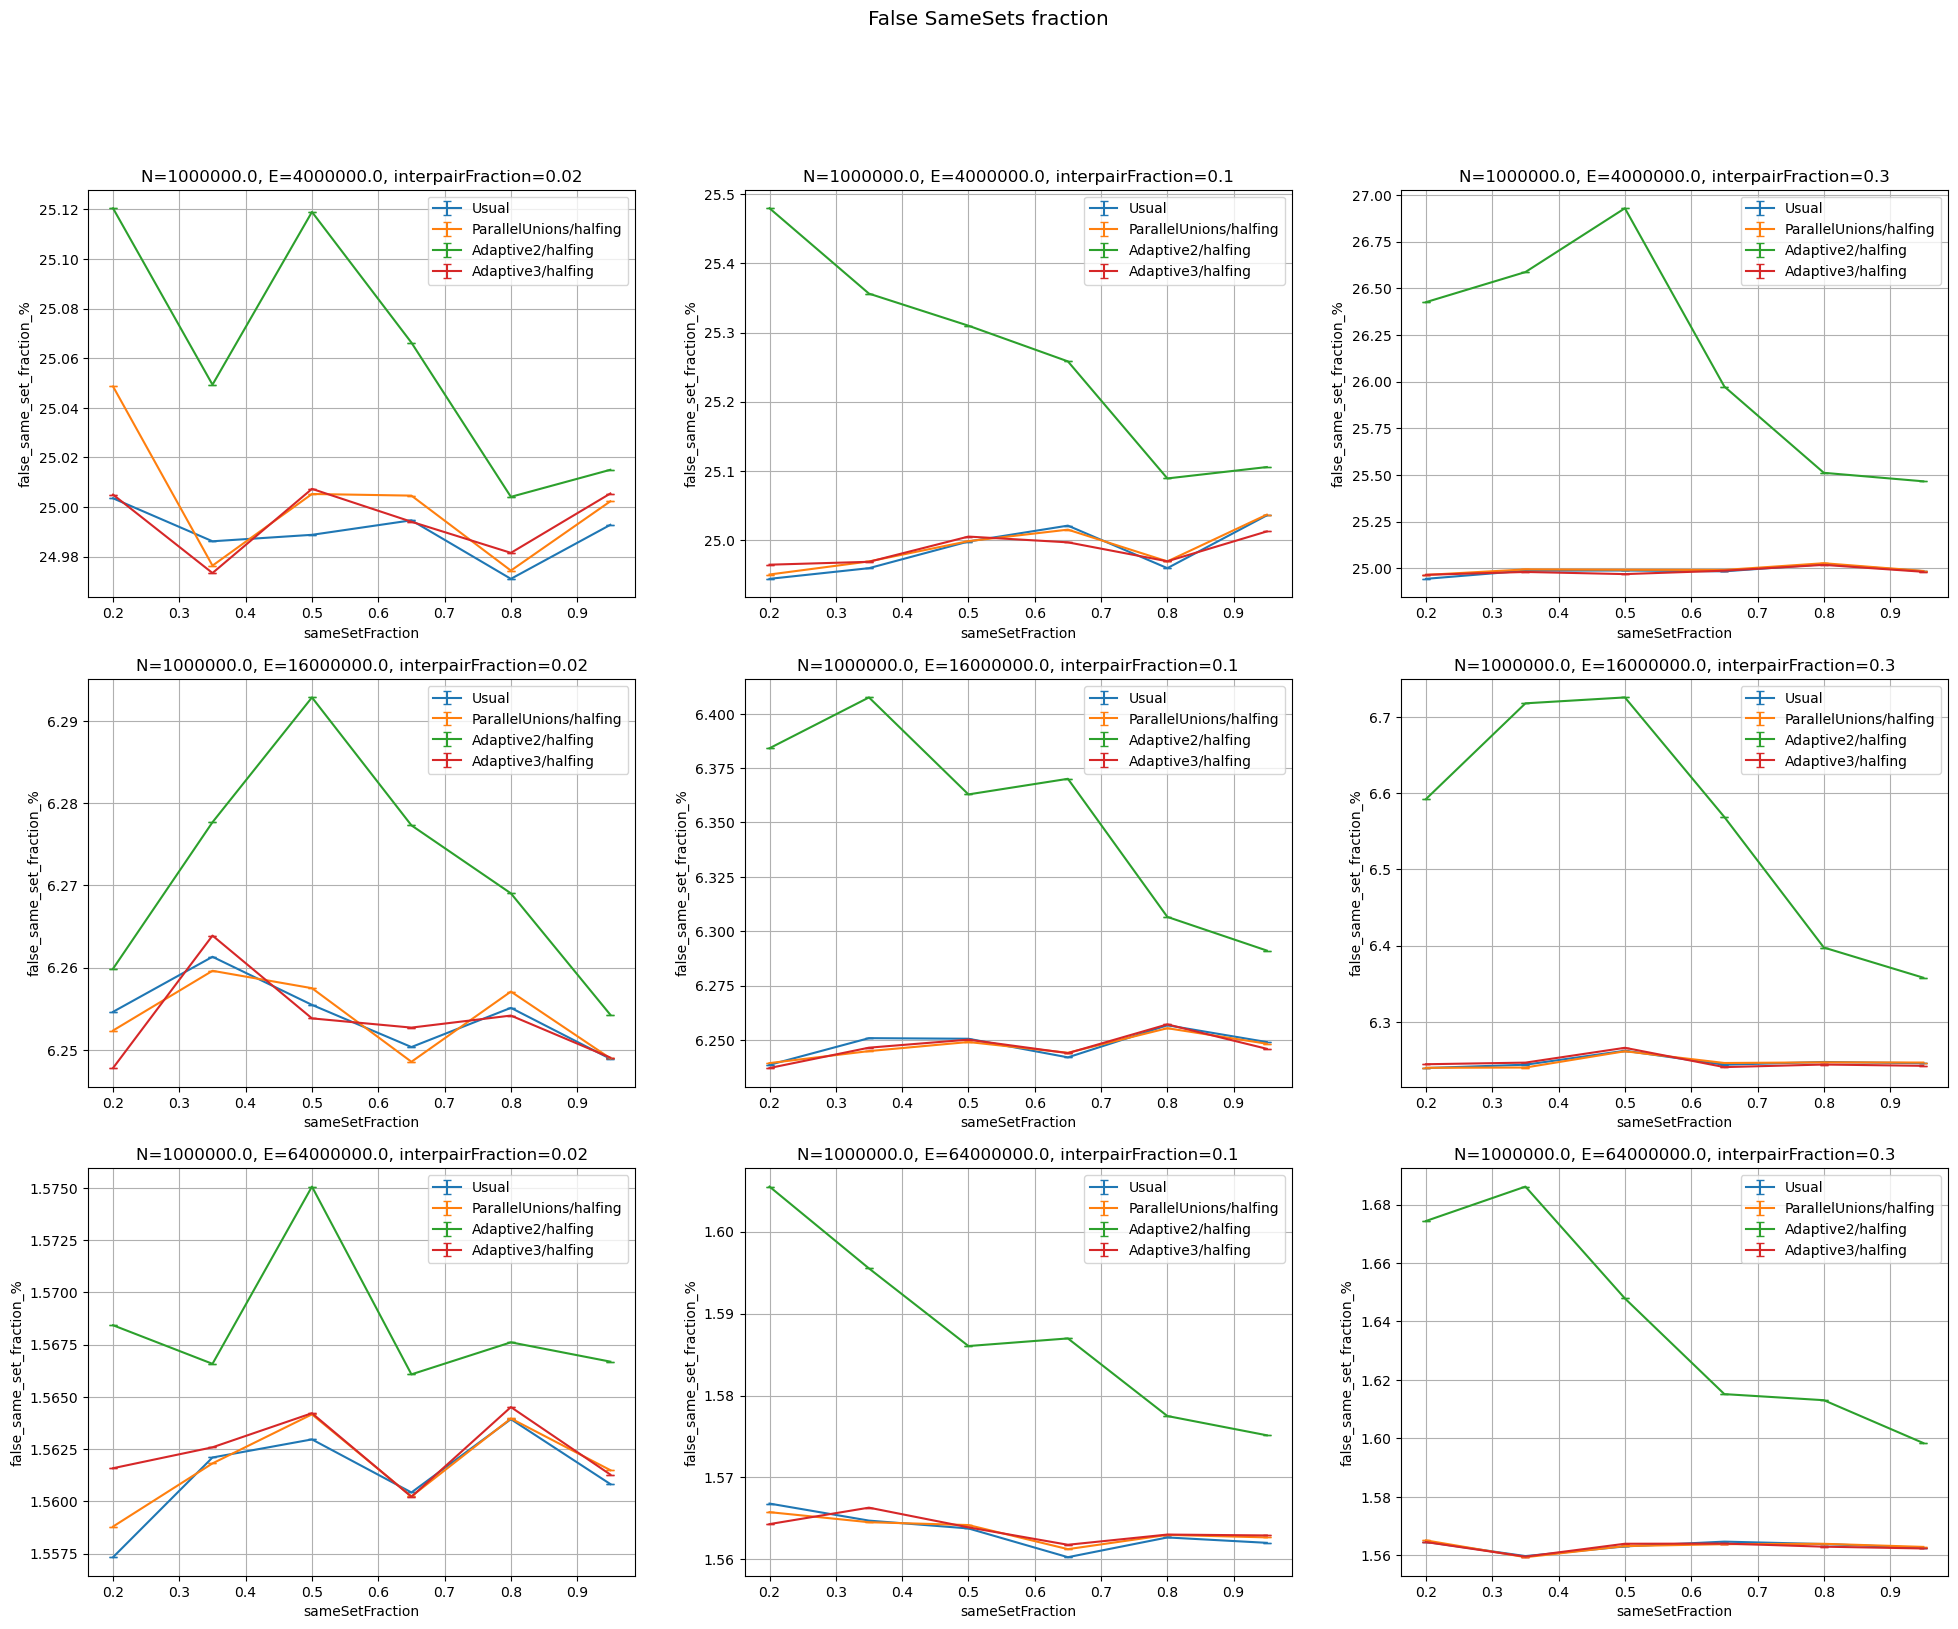

In [30]:
def prod_same_set_false(rows):
    res = rows.reset_index(inplace=False).loc[1].copy()
    rows = rows.set_index("Metric")
    score = rows.loc["same_set_requests_false"]["Score"] / (rows.loc["same_set_requests_false"]["Score"] + rows.loc["same_set_requests_true"]["Score"]) * 100
    res["Metric"] = "false_same_set_fraction_%"
    res["Score"] = score
    res["Score Error"] = 0.0
    res = res.drop("index")
    return res
m2 = emit_metric(met, prod_same_set_false)
plot_met(m2, "false_same_set_fraction_%", "sameSetFraction", "DSU", halfing_dsus)
plt.suptitle("False SameSets fraction", fontsize='x-large');

# Experiments with stages

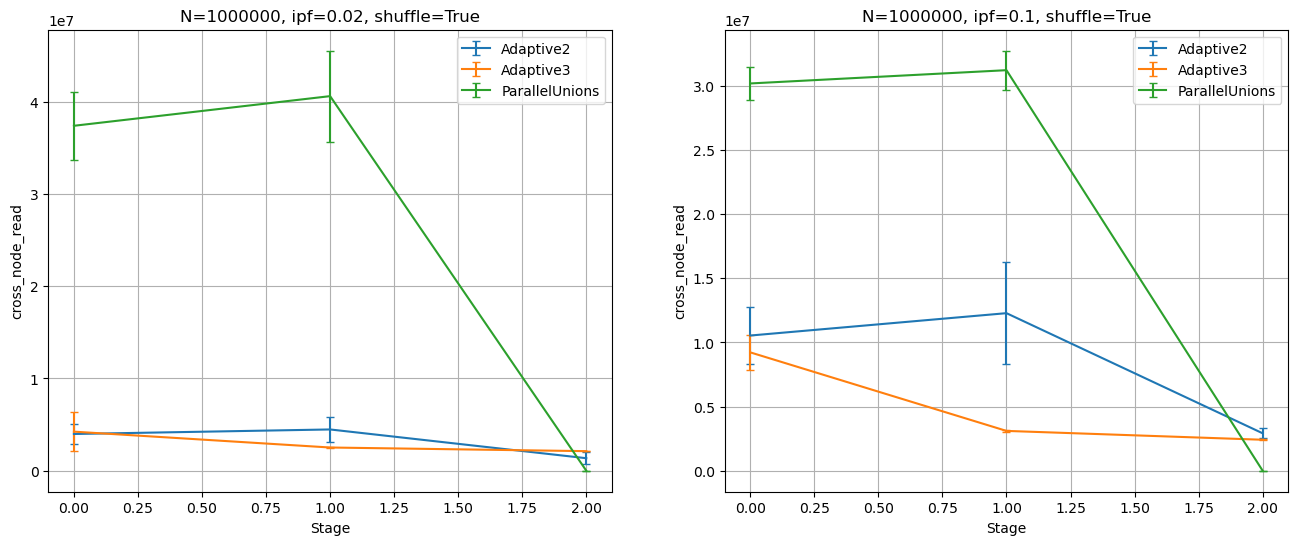

In [64]:
data = pd.read_csv("measurements/out-staged-4M.csv")
plot_met(data, "cross_node_read", "Stage", "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus)), nc=2)

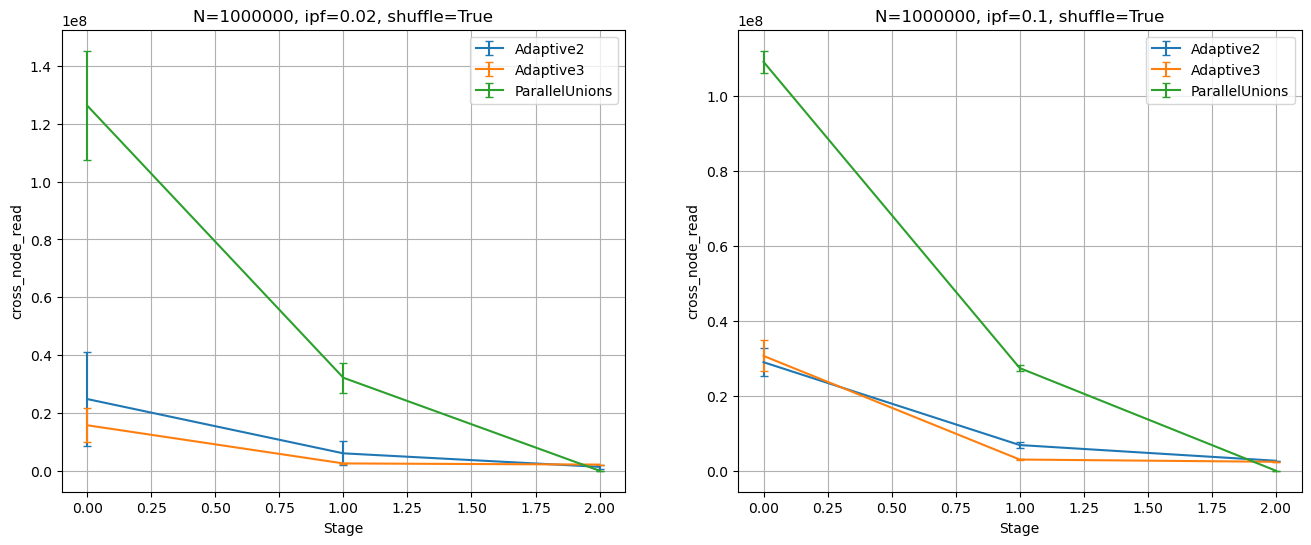

In [63]:
data = pd.read_csv("measurements/out-staged-16M.csv")
plot_met(data, "cross_node_read", "Stage", "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus)), nc=2)

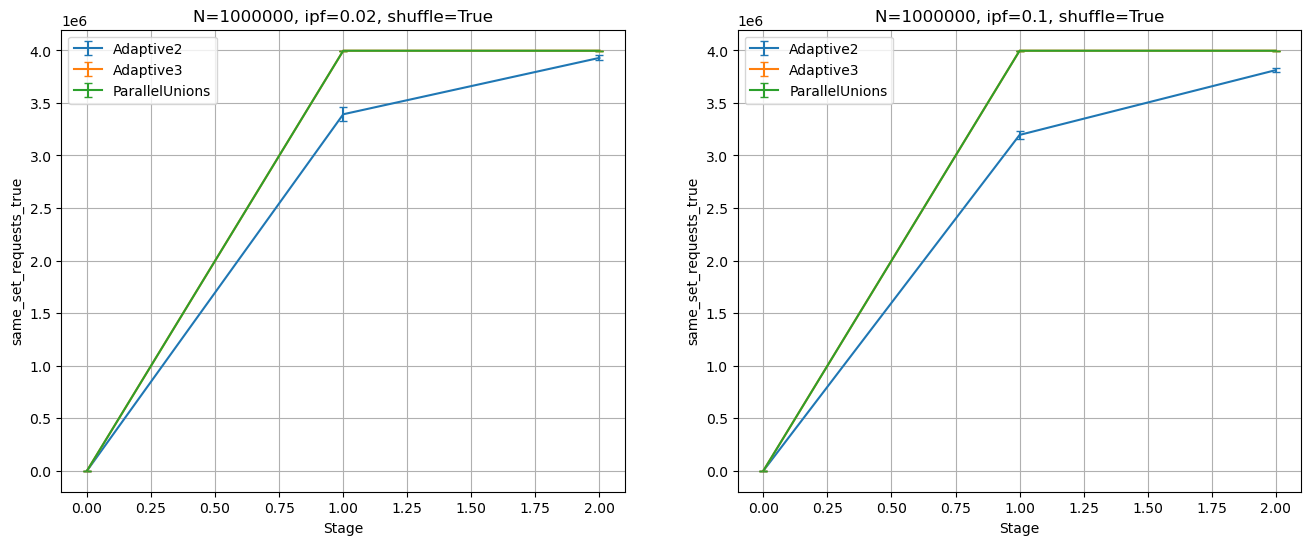

In [61]:
data = pd.read_csv("measurements/out-staged-4M.csv")
plot_met(data, "same_set_requests_true", "Stage", "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus)), nc=2)

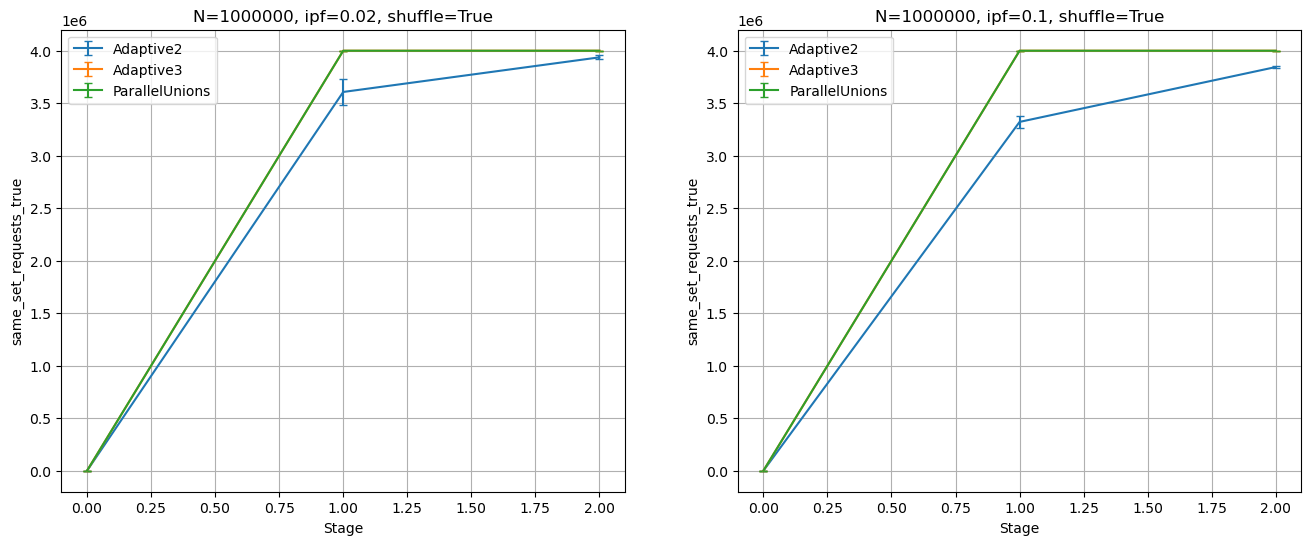

In [62]:
data = pd.read_csv("measurements/out-staged-16M.csv")
plot_met(data, "same_set_requests_true", "Stage", "DSU", cut_field(["E", "ssf"], strip_subtype(halfing_dsus)), nc=2)